In [15]:
# -*- coding: utf-8 -*-
'''
Computa els canvis registrats en el taulell de joc i ho passa al Mòdul Control.
'''
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import time
import math

class Visio():
    def __init__(self):
        self.background = None        
        self.frame = None
        self.grayFrame = None
        
        self.patroFitxa = None
        self.midaFixa = (0,0) #width,height
        self.rotacioDefecte = 0.0
        
        self.estatPartida = {}
        
    ###################################################################
    
    def updateFrame(self,frame):
        self.frame = frame
        self.grayFrame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
               
        self.backgroundSubstraction()
    
    ##### backgroundSubstraction #####
    def backgroundSubstraction(self, debug=False):
        if self.background is None:
            self.background = self.grayFrame
        else:
            self.background = cv.absdiff(self.background,self.grayFrame)
        if debug:
            cv.imshow("Debug visio: backgroundSubstraction",self.background)
    
    ###################################################################
    def mostrarResultat(self, debug = False):
        im = self.frame
        for d in self.estatPartida:
            if debug:
                print(d,':',self.estatPartida[d])
            punts = self.estatPartida[d][1]
            x,y,w,h = self.estatPartida[d][0]
            orientacio = self.estatPartida[d][2]
            margin=20
            if orientacio == 0:
                x1=x-margin
                y1=y+int(h/2)
                x2=x+w
                y2=y+int(h/2)
                im =cv.putText(im,str(punts[0]),(x1,y1), cv.FONT_HERSHEY_SIMPLEX, 1,(0,255,0),2,cv.LINE_AA)
                im =cv.putText(im,str(punts[1]),(x2,y2), cv.FONT_HERSHEY_SIMPLEX, 1,(0,255,0),2,cv.LINE_AA)
            else:
                x1=x+int(w/2)
                y1=y
                x2=x+int(w/2)
                y2=y+h+margin
                im =cv.putText(im,str(punts[0]),(x1,y1), cv.FONT_HERSHEY_SIMPLEX, 1,(255,0,0),2,cv.LINE_AA)
                im =cv.putText(im,str(punts[1]),(x2,y2), cv.FONT_HERSHEY_SIMPLEX, 1,(255,0,0),2,cv.LINE_AA)            
            if debug:
                im =cv.putText(im,str(d),(x+int(w/2),(y+int(h/2))), cv.FONT_HERSHEY_SIMPLEX, 1,(0,0,255),2,cv.LINE_AA)
        im.astype('uint8')
        return im
        
        
    ##### processarFrame #####
    def processarFrame(self, debug=False):
        # Aplicar threshold
        #_,threshold = cv.threshold(self.grayFrame,127,255,cv.THRESH_BINARY)
        _,threshold = cv.threshold(self.frame,127,255,cv.THRESH_BINARY)
        # Aplicar filtre Gaussia
        threshold = cv.GaussianBlur(threshold,(5,5),0)
        
        # Creem imatge 2D per trobar contorns
        contorns = threshold[:,:,0]
        #Trobem els contorns presents en la imatge
        contours, hierarchy = cv.findContours(contorns,cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        
        dictContorns = {}
        
        '''
        contarPunts(hierarchy)
        '''
        # Per cada contorn c
        for i,c in enumerate(contours):
            pare = hierarchy[0][i,3]
            # Si el contorn actual esta dins d'algun altre (es un punt)
            if pare != -1:
                # registrem les dades de la fitxa a la que pertany el punt a la variable cos
                # cos -> (x,y,width,height)
                cos = cv.boundingRect(contours[pare])
                # registrem les dades del punt actual
                x,y,w,h = cv.boundingRect(contours[i])
                punts=[0,0]
                orientacio=0
                #Comprovem l'orientacio de la fitxa i assignem el punt a un dels costats
                if cos[2] > cos[3]:
                    # Horitzontal
                    orientacio=0
                    if x < cos[0]+int(cos[2]/2):
                        punts=[1,0] # Esquerra
                    else:
                        punts=[0,1] # Dreta
                elif cos[2] < cos[3]:
                    # Vertical
                    orientacio=1
                    if y < cos[1]+int(cos[3]/2):
                        punts=[1,0] # Superior
                    else:
                        punts=[0,1] # Inferior
                else:
                    print('Error!')
                    pass          

                # Si la fitxa no existeix en el diccionari, la afegim amb totes les dades que hem recollit
                if not str(pare) in dictContorns:
                    dictContorns[str(pare)]=[cos,punts,orientacio]
                # Si la fitxa si existeix, modifiquem el camp punts afegint el punt trobat al canto corresponent
                else:               
                    dictContorns[str(pare)][1][0]+=punts[0]
                    dictContorns[str(pare)][1][1]+=punts[1]           
    
        if debug:
            cv.imshow("Debug visio: processarFrame",self.background)
        self.estatPartida = dictContorns
        return dictContorns
    
    
    
    def getFirstFeatures(self, debug = False):
        im = self.frame.copy()
        _, threshold = cv.threshold(self.frame,127,255,cv.THRESH_BINARY)
        threshold = cv.GaussianBlur(threshold,(5,5),0)
        
        contorns = threshold[:,:,0]
        contours, hierarchy = cv.findContours(contorns,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
        
        
        posicio = (0,0)
        rotacio = 0.0
        midaFitxa = (0,0) #w,h
        fitxaTrobada=False
        for i,c in enumerate(contours):  
            if hierarchy[0][i,3]==-1:
                # Calculem els vertex maxim i minim i la rotacio del contorn            
                rect = cv.minAreaRect(contours[i])  
                # rect -> (center (x,y), (width, height), angle of rotation )
                # Definim la posicio de la fitxa
                posicio = rect[0]
                # Definim la mida de la fitxa
                midaFitxa = rect[1]
                # Definim la rotacio alpha de la fitxa
                rotacio = rect[2]
                fitxaTrobada = True
                break
                '''
                #
                #
                #
                M = cv.getRotationMatrix2D((im.shape[1]/2,im.shape[0]/2),rotacioAlpha,1)
                dst = cv.warpAffine(im,M,(im.shape[1],im.shape[0]))
                #
                #
                #
                '''
        template=np.zeros((20,10),dtype=np.uint8)
        if fitxaTrobada:
            # Trobar una plantilla del centre de una fitxa per trobar les demes
            rows,cols,_ = im.shape

            x = int(posicio[0])
            y = int(posicio[1])


            width = int(midaFitxa[0])
            height = int(midaFitxa[1])

            centerX = int(cols/2)
            centerY = int(rows/2)

            h_gap = centerX - x
            v_gap = centerY - y

            # Traslacio al centre
            M = np.float32([[1,0,h_gap],[0,1,v_gap]])
            dst = cv.warpAffine(im,M,(cols,rows))

            # Rotacio
            if width > height:
                rotacioOrigen = 90+rotacio
            else:
                rotacioOrigen=rotacio
                temp = width
                width = height
                height = temp

            M = cv.getRotationMatrix2D((cols/2,rows/2),rotacioOrigen,1)
            dst = cv.warpAffine(dst,M,(cols,rows))

            # ROI
            templateHeight = height*0.2
            templateWidth = width*0.5
            template = dst[ centerY-int(templateHeight*0.5):centerY+int(templateHeight*0.5) , centerX-int(templateWidth*0.5) : centerX+int(templateWidth*0.5)]

            if debug :
                plt.figure()
                plt.imshow(template)
                print('Amplada: {}, Alcada: {}, Rotacio: {}'.format(midaFitxa[0],midaFitxa[1],rotacio))
                print('Temps execució: %.3f segons' %(time.time()-start))

        return (posicio,midaFitxa,rotacio),template 

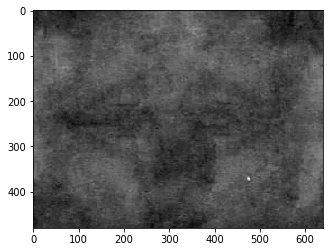

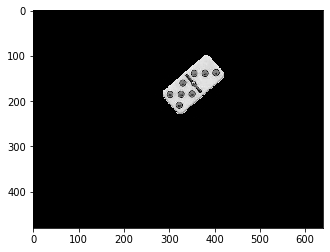

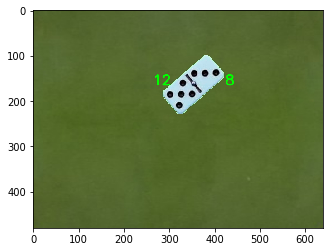

In [16]:
if __name__ == '__main__':
    bg = cv.imread('tapete.jpg')
    frame = cv.imread('unauna.jpg')  
    v = Visio()
    
    v.updateFrame(bg)    
    plt.figure()
    plt.imshow(v.background,'gray')
    
    v.updateFrame(frame)
    plt.figure()
    plt.imshow(v.background,'gray')
    v.processarFrame()
    plt.figure()
    plt.imshow(v.mostrarResultat(),'gray')
    